In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.autonotebook import tqdm

from scipy import misc

%matplotlib inline
%config Completer.use_jedi = False

plt.rcParams['figure.figsize'] = (10, 10)

/Users/agarbuno/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


# Filtros para imágenes

In [2]:
from skimage import color
from skimage import io
from skimage.transform import rescale, resize

trooper = io.imread('../images/trooper.png', as_gray = True)

down_scaling = .30
trooper = rescale(trooper, scale= down_scaling)

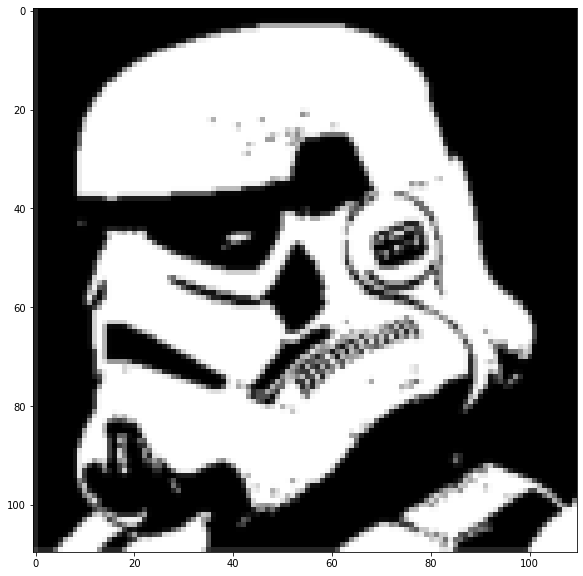

In [3]:
# Veamos la imagen que cargamos
plt.imshow(trooper, cmap = 'gray')
plt.show()

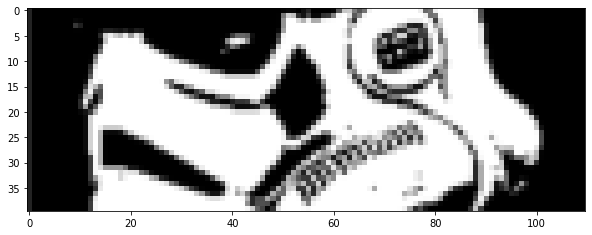

In [4]:
# O una porción de la imagen
plt.imshow(trooper[40:80, :], cmap = 'gray')
plt.show()

### Learning Activity 3: Define and apply a convolution function

Now lets define a convolution function. First you must define a function which traverses the image to apply the convolution at every point and returns the result in a filtered image. Calculating the size of the filtered image along each dimension can be a little tricky, the formula is: 

                         Size of the filtered image = input image size - filter size + 1

Let us start by implementing the `convolve` function. It takes as input an image and a filter, and returns
the output of applying the filter at each position in the image through a function `multiply_sum`

In [5]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = tf.Variable(tf.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j].assign(tf.reduce_sum(
                X[i: i + h, j: j + w] * K))
    return Y

In [6]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = tf.constant([[0.0, 1.0], [2.0, 3.0]])

print("Original: \n", X.numpy())
print("\nFiltro: \n", K.numpy())
print("\nResultado: \n", corr2d(X, K).numpy())

Original: 
 [[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]

Filtro: 
 [[0. 1.]
 [2. 3.]]

Resultado: 
 [[19. 25.]
 [37. 43.]]


In [7]:
K = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]])

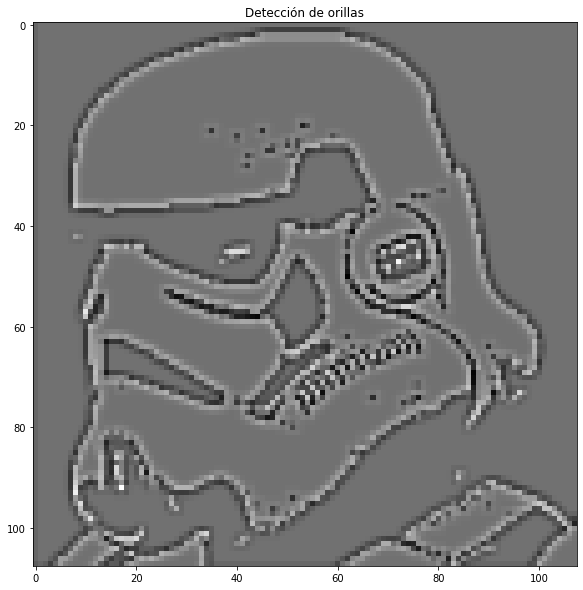

In [8]:
filtered_tensor = corr2d(
       tf.convert_to_tensor(trooper, dtype = tf.float32), 
       tf.convert_to_tensor(K,       dtype = tf.float32)
    )

plt.imshow(filtered_tensor.numpy(), cmap = 'gray');
plt.title("Detección de orillas");
plt.show();

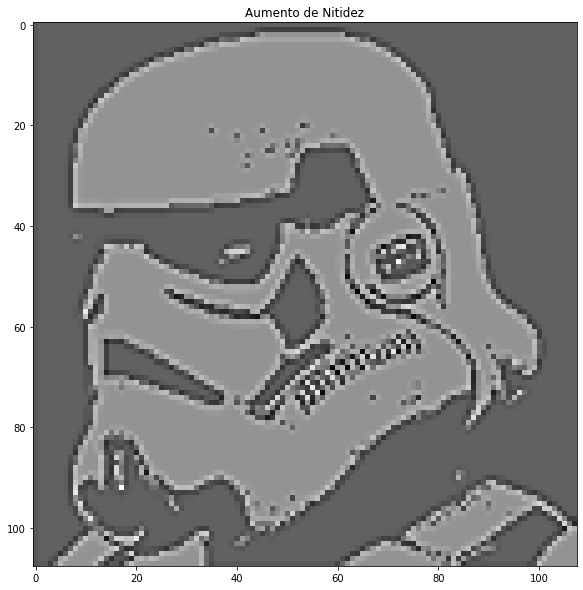

In [9]:
K = np.array([[ 0, -1,  0],
              [-1,  5, -1],
              [ 0, -1,  0]])

filtered_tensor = corr2d(
       tf.convert_to_tensor(trooper, dtype = tf.float32), 
       tf.convert_to_tensor(K,       dtype = tf.float32)
    )

plt.imshow(filtered_tensor.numpy(), cmap = 'gray');
plt.title("Aumento de Nitidez");
plt.show();

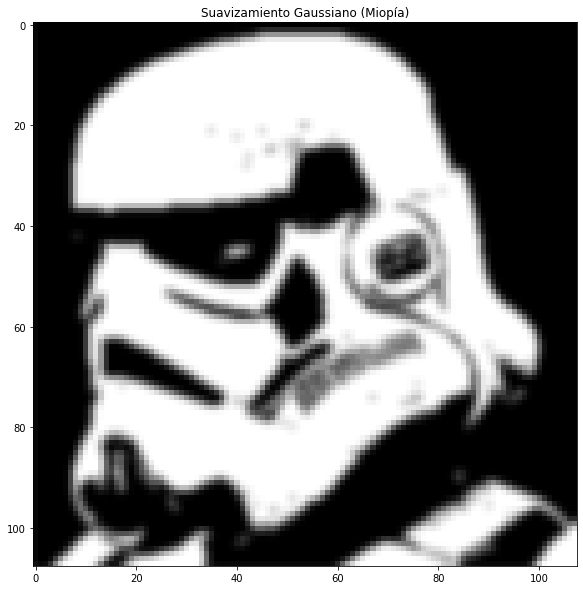

In [10]:
K = np.array([[1, 2, 1],
              [2, 4, 2],
              [1, 2, 1]])/16

filtered_tensor = corr2d(
       tf.convert_to_tensor(trooper, dtype = tf.float32), 
       tf.convert_to_tensor(K,       dtype = tf.float32)
    )

plt.imshow(filtered_tensor.numpy(), cmap = 'gray');
plt.title("Suavizamiento Gaussiano (Miopía)");
plt.show();

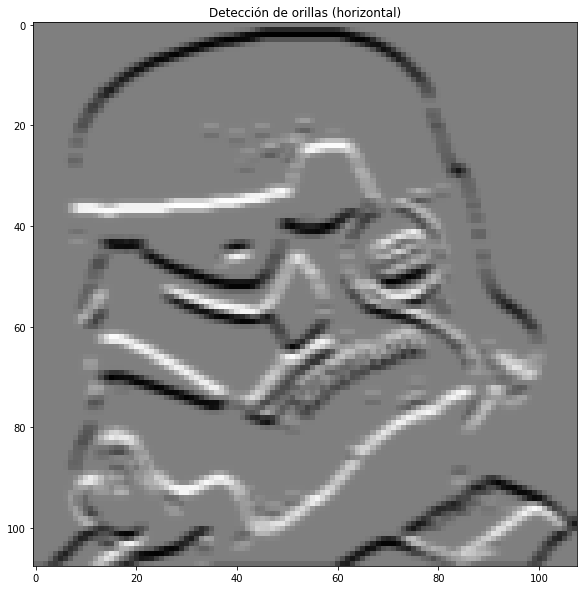

In [11]:
K = np.array([[1, 1, 1],
              [ 0, 0, 0],
              [-1, -1, -1]])
filtered_tensor = corr2d(
       tf.convert_to_tensor(trooper, dtype = tf.float32), 
       tf.convert_to_tensor(K,       dtype = tf.float32)
    )

plt.imshow(filtered_tensor.numpy(), cmap = 'gray');
plt.title("Detección de orillas (horizontal)");
plt.show();

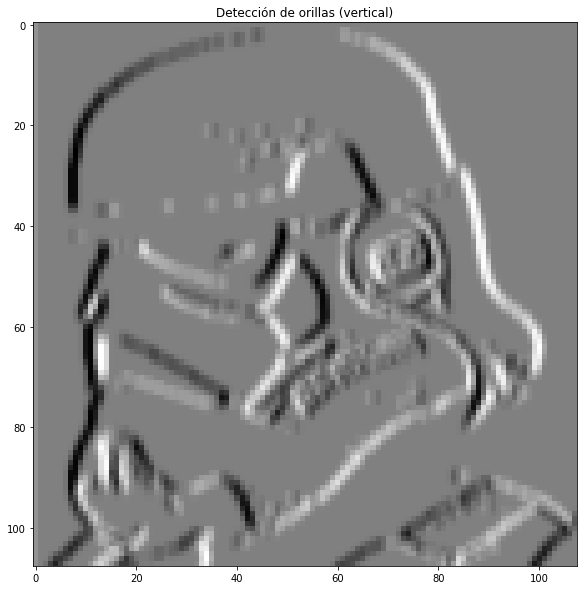

In [12]:
filtered_tensor = corr2d(
       tf.convert_to_tensor(trooper,       dtype = tf.float32), 
       tf.convert_to_tensor(K.transpose(), dtype = tf.float32)
    )

plt.imshow(filtered_tensor.numpy(), cmap = 'gray');
plt.title("Detección de orillas (vertical)");
plt.show();

## Filtros con canales multiples

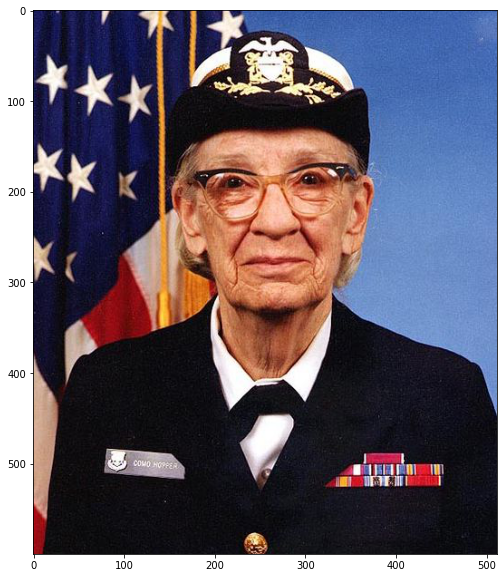

In [13]:
# Read and show the Grace Hopper portrait
grace_hopper_colour = io.imread('../images/grace_hopper.jpg')
plt.imshow(grace_hopper_colour)
plt.show()

down_scaling = .30
grace_hopper_color = rescale(grace_hopper_colour, scale= down_scaling, multichannel= True)

In [14]:
from tensorflow.keras.utils import get_file

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

weights_path = get_file(
          'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
          WEIGHTS_PATH,
          cache_subdir='models',
          file_hash='64373286793e3c8b2b4e3219cbf3544b')

model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [15]:
filters, biases = model.layers[1].get_weights()

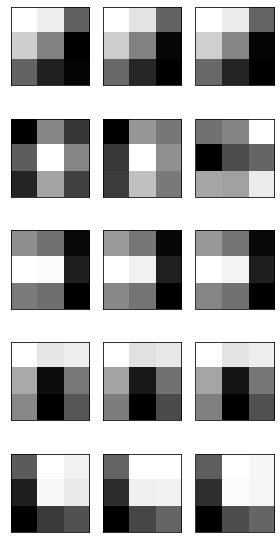

In [16]:
n_filters = 5
fig, axes = plt.subplots(n_filters, 3, figsize = [4, 8])

for jj in np.arange(n_filters):
    for kk, ax in enumerate(axes[jj,:]):
        ax.imshow(filters[:,:,kk,jj], cmap = 'gray');
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

Filters:   0%|          | 0/5 [00:00<?, ?it/s]

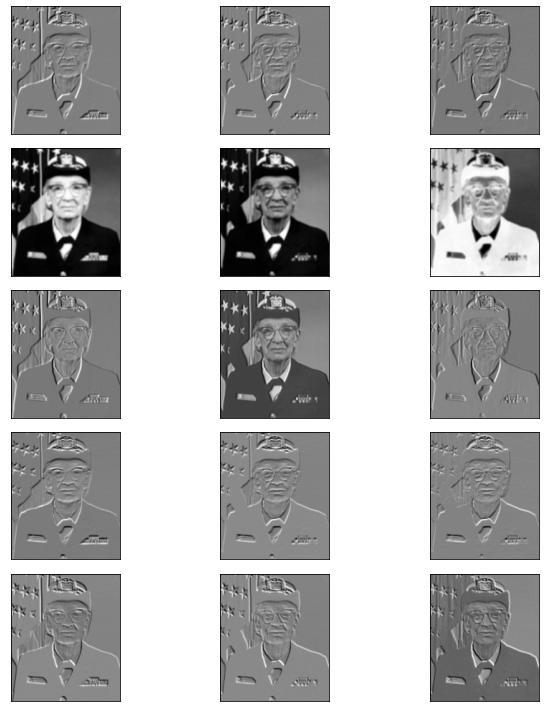

In [18]:
color_id  = 1
filter_id = 1

fig, axes = plt.subplots(5, 3)

for filter_id in tqdm(np.arange(5), desc = "Filters: "):
    for color_id in np.arange(3):
        filtered_tensor = corr2d(
               tf.convert_to_tensor(grace_hopper_color[:,:,color_id],dtype = tf.float32), 
               tf.convert_to_tensor(filters[:,:,color_id,filter_id], dtype = tf.float32)
            )

        axes[filter_id, color_id].imshow(filtered_tensor.numpy(), cmap = 'gray');
        axes[filter_id, color_id].set_xticks([])
        axes[filter_id, color_id].set_yticks([])

fig.tight_layout()